# IMERG Data Access

The notebook uses `earthaccess` to download and examine precipitation from Integrated Multi-Satellite Retrievals for GPM (IMERG). Although not strictly snow-based, this information is useful to infer mid-latitude snowfall.

This script was adapted from the GES DISC Github, which can be found here: https://github.com/nasa/gesdisc-tutorials/blob/main/notebooks/How_to_Read_IMERG_Data_Using_Python.ipynb

In [1]:
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm

As with other workbooks, we are using `earthaccess` to get the IMERG data globally. We will be grabbing a single days' worth of data for this example.

In [2]:
# Authenticate with Earthdata Login servers
auth = earthaccess.login()

# Search for granules
results = earthaccess.search_data(
    short_name="GPM_3IMERGM",
    version="07",
    temporal=('2022-03-01', '2022-03-01'),
    bounding_box=(-180, 0, 180, 90)
)

In [3]:
# Download the granule to the current working directory
downloaded_files = earthaccess.download(
    results,
    local_path='/home/jovyan/tmp/', # Change this string to download to a different path
)

In [4]:
ds = xr.open_mfdataset(downloaded_files, group="Grid")
ds

<xarray.Dataset> Size: 130MB
Dimensions:                         (time: 1, lon: 3600, lat: 1800, nv: 2,
                                     lonv: 2, latv: 2)
Coordinates:
  * time                            (time) object 8B 2022-03-01 00:00:00
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
Dimensions without coordinates: nv, lonv, latv
Data variables:
    time_bnds                       (time, nv) object 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (lon, lonv) float32 29kB dask.array<chunksize=(3600, 2), meta=np.ndarray>
    lat_bnds                        (lat, latv) float32 14kB dask.array<chunksize=(1800, 2), meta=np.ndarray>
    precipitation                   (time, lon, lat) float32 26MB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 26MB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lon, lat) float32 26MB dask.array<chunksize=(1, 291, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 26MB dask.array<chunksize=(1, 291, 1800), meta=np.ndarray>
    precipitationQualityIndex       (time, lon, lat) float32 26MB dask.array<chunksize=(1, 145, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

As we can see, the IMERG data has several variables for potential analysis, including the precipitation rate (`precipitation`) and the probability of liquid precipitation (`probabilityLiquidPrecipitation`). We will make plots of both of these variables for this example.

To load the data into memory, we are going to place the values into numpy arrays. This is roughly the same as using the `compute()` function on a lazy-loaded DataArray, though it might not be as effective if you wish to use multiple days or time steps.

In [11]:
# Get the precipitation, latitude, and longitude variables
precip = ds['precipitation'][0,:,:].values
precip = np.transpose(precip)
probPrecip = ds['probabilityLiquidPrecipitation'][0,:,:].values
probPrecip = np.transpose(probPrecip)
theLats = ds['lat'].values
theLons = ds['lon'].values
x, y = np.float32(np.meshgrid(theLons, theLats))

Finally, let's make contour maps of precipitation and liquid precipitation probability.

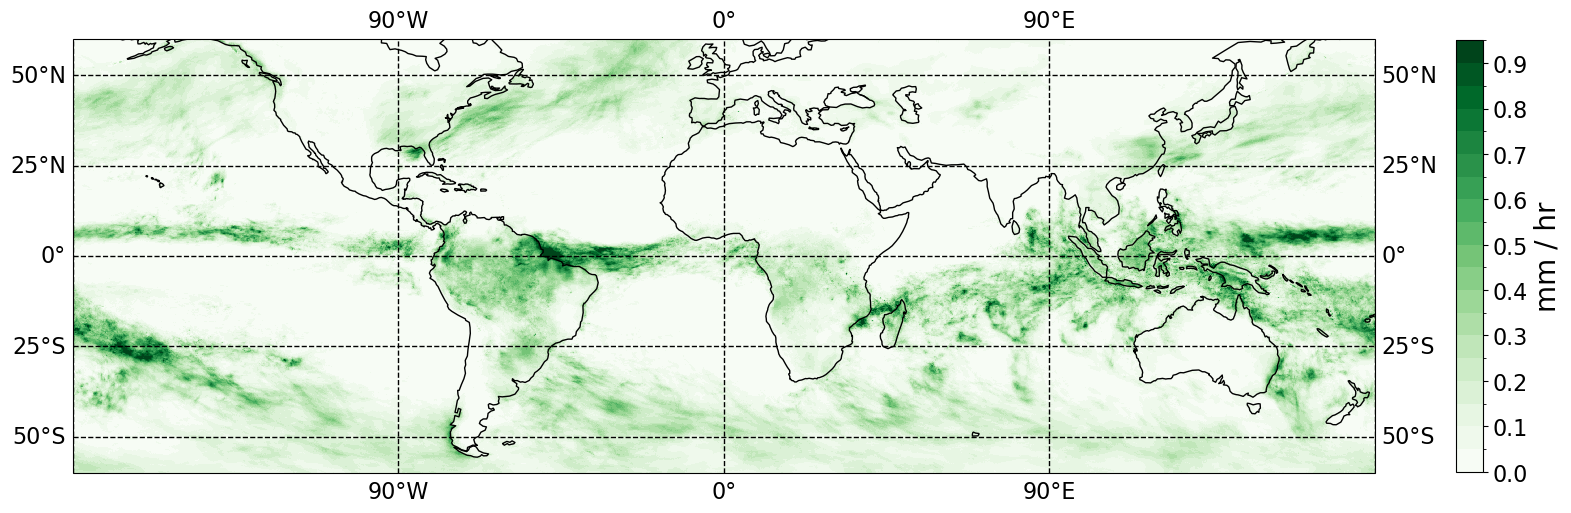

In [24]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(21, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -60, 60])  

# Add coastlines and formatted gridlines
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}

# Set contour levels
clevs = np.arange(0, 1, 0.05)

# Normalize the data to match clevs
norm = BoundaryNorm(clevs, ncolors=plt.cm.rainbow.N, clip=True)

# Plot the data with pcolormesh
mesh = plt.pcolormesh(x, y, precip, cmap="Greens", norm=norm, shading="auto")

# Add a colorbar
cb = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.05, aspect=16, shrink=0.8)
cb.set_label('mm / hr', size=20)
cb.ax.tick_params(labelsize=16)

# Add a title
#plt.title('GPM IMERG Monthly Mean Rain Rate for January 2014', size=24)

# Show the plot
plt.show()

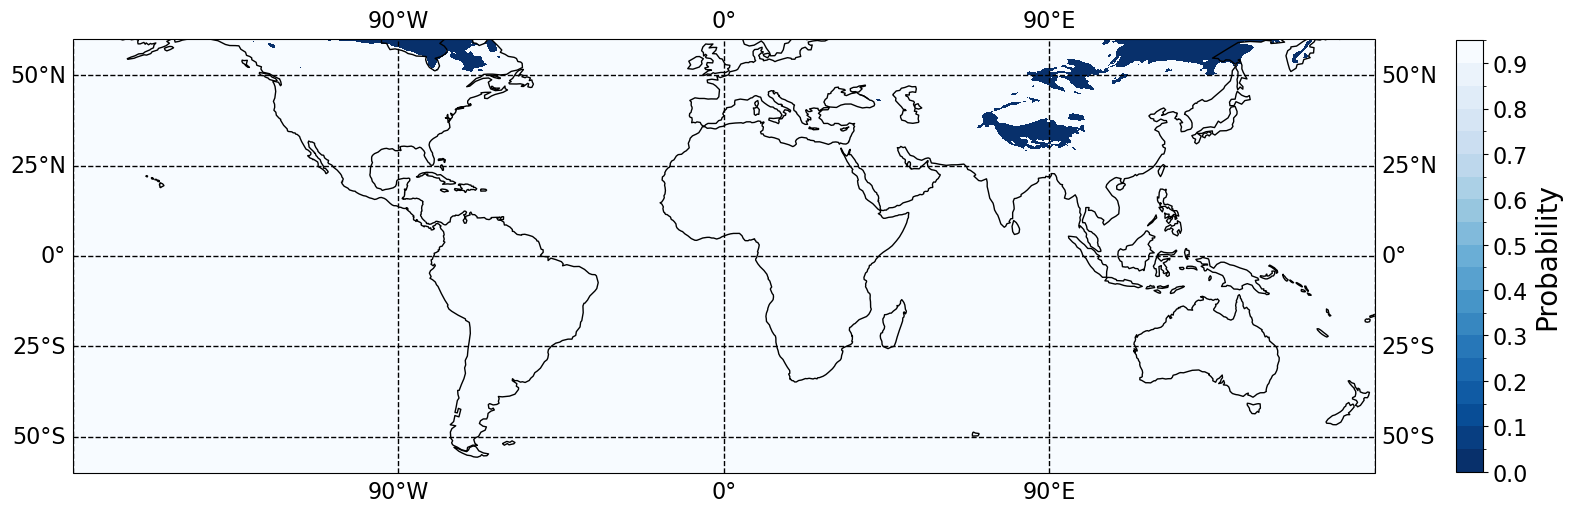

In [21]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(21, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -60, 60])  

# Add coastlines and formatted gridlines
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}

# Set contour levels
clevs = np.arange(0, 1, 0.05)

# Normalize the data to match clevs
norm = BoundaryNorm(clevs, ncolors=plt.cm.rainbow.N, clip=True)

# Plot the data with pcolormesh
mesh = plt.pcolormesh(x, y, probPrecip, cmap="Blues_r", norm=norm, shading="auto")

# Add a colorbar
cb = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.05, aspect=16, shrink=0.8)
cb.set_label('Probability', size=20)
cb.ax.tick_params(labelsize=16)

# Add a title
#plt.title('GPM IMERG Monthly Mean Rain Rate for January 2014', size=24)

# Show the plot
plt.show()

Note that IMERG only observes up to 60 degrees N/S, meaning that we can't use it for high-latitude analysis. However, it's still useful for mid-latitude applications!